In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm
import time
import seaborn as sns
from IPython.display import clear_output

In [ ]:
import torch
from torch import nn
from torch.nn import functional
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from torchvision import datasets, transforms, utils
import torch.optim as optim

In [ ]:
from collections import defaultdict
import random

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


### Подготовка данных

Разархивируем данные.

In [ ]:
# Путь до архива с данными
ZIP_PATH = 'archive'
# Путь для папки с данными
DATA_PATH = 'images'

In [ ]:
%%time
! unzip $ZIP_PATH -d $DATA_PATH

Archive:  archive.zip
  inflating: images/images/Abomasnow/0.jpg  
  inflating: images/images/Abomasnow/1.jpg  
  inflating: images/images/Abomasnow/2.jpg  
  inflating: images/images/Abomasnow/3.jpg  
  inflating: images/images/Abra/0.jpg  
  inflating: images/images/Abra/1.jpg  
  inflating: images/images/Abra/2.jpg  
  inflating: images/images/Abra/3.jpg  
  inflating: images/images/Absol/0.jpg  
  inflating: images/images/Absol/1.jpg  
  inflating: images/images/Absol/2.jpg  
  inflating: images/images/Absol/3.jpg  
  inflating: images/images/Accelgor/0.jpg  
  inflating: images/images/Accelgor/1.jpg  
  inflating: images/images/Aegislash/0.jpg  
  inflating: images/images/Aegislash/1.jpg  
  inflating: images/images/Aegislash/2.jpg  
  inflating: images/images/Aegislash/3.jpg  
  inflating: images/images/Aerodactyl/0.jpg  
  inflating: images/images/Aerodactyl/1.jpg  
  inflating: images/images/Aerodactyl/2.jpg  
  inflating: images/images/Aerodactyl/3.jpg  
  inflating: images/im

Для тренировки GAN нужны очень большие датасеты. Увеличим объем входных данных с помощью аугментаций. Сначала будем использовать только изменения входных изображений, которые допустимы и в сгенерированных изображениях. Например, зеркальное отражение и изменение цвета. Также уменьшим размер, чтобы дискриминатор хуже переобучался

In [ ]:
transform = transforms.Compose([transforms.Resize((64, 64)),
                                transforms.ColorJitter(saturation=1, hue=0.5),
                                transforms.RandomHorizontalFlip(p=0.5),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [ ]:
dataset = datasets.ImageFolder('images/images', transform=transform)

In [ ]:
batch_size = 32
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=2)

Посмотрим на несколько изображений:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


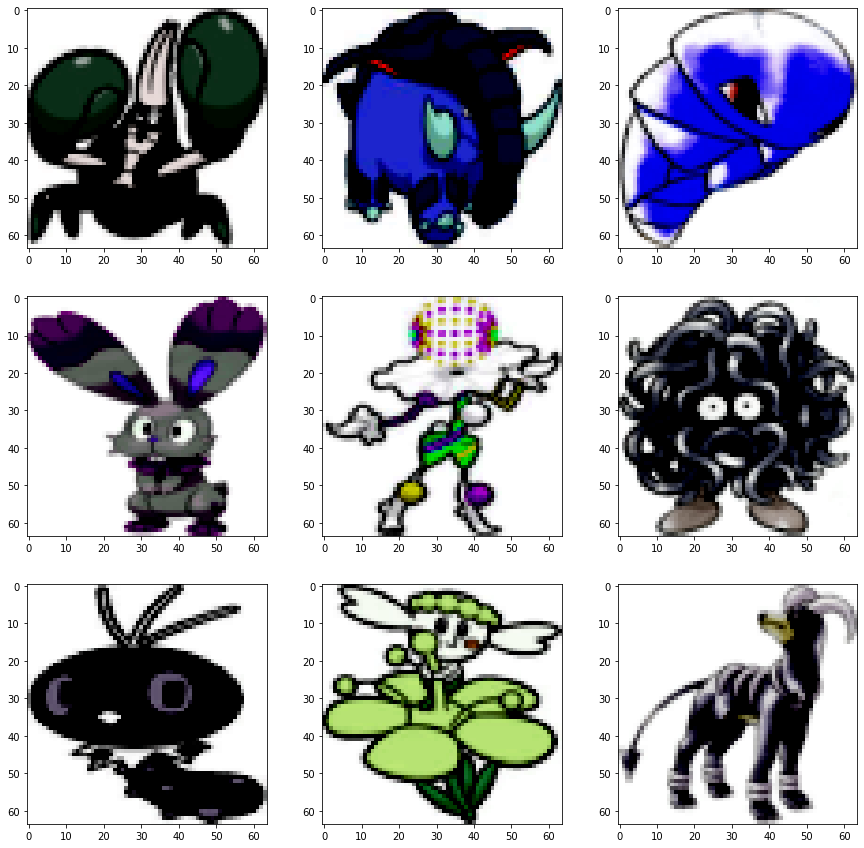

In [ ]:
images, labels = next(iter(dataloader))

fig, ax = plt.subplots(3, 3, figsize=(15, 15))
for i in range(3):
  for j in range(3):
    ax[i][j].imshow(np.transpose(images[3*i + j], (1, 2, 0)))

### Baseline

Первая модель будет состоять из генератора и дискриминатора со сверточными слоями

In [ ]:
class Generator(nn.Module):
  def __init__(self, input_length):
    super().__init__()
    self.layers = nn.Sequential(
        nn.ConvTranspose2d(input_length, 512, 4, 1, 0, bias=False),
        nn.BatchNorm2d(512),
        nn.ReLU(True),
        # 512 x 4 x 4

        nn.ConvTranspose2d(512, 256, 4, 2, 1, bias=False),
        nn.BatchNorm2d(256),
        nn.ReLU(True),
        # 256 x 8 x 8

        nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),
        nn.BatchNorm2d(128),
        nn.ReLU(True),
        # 128 x 16 x 16

        nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False),
        nn.BatchNorm2d(64),
        nn.ReLU(True),
        # 64 x 32 x 32

        nn.ConvTranspose2d(64, 3, 4, 2, 1, bias=False),
        nn.Tanh()
        # 3 x 64 x 64
    )

  def forward(self, input):
    return self.layers(input)

In [ ]:
class Discriminator(nn.Module):
  def __init__(self):
    super().__init__()
    self.layers = nn.Sequential(
        # 3 x 64 x 64

        nn.Conv2d(3, 64, 4, 2, 1, bias=False),
        nn.BatchNorm2d(64),
        nn.LeakyReLU(0.2, inplace=True),
        # 64 x 32 x 32

        nn.Conv2d(64, 128, 4, 2, 1, bias=False),
        nn.BatchNorm2d(128),
        nn.LeakyReLU(0.2, inplace=True),
        # 128 x 16 x 16

        nn.Conv2d(128, 256, 4, 2, 1, bias=False),
        nn.BatchNorm2d(256),
        nn.LeakyReLU(0.2, inplace=True),
        # 256 x 8 x 8

        nn.Conv2d(256, 512, 4, 2, 1, bias=False),
        nn.BatchNorm2d(512),
        nn.LeakyReLU(True),
        # 512 x 4 x 4

        nn.Conv2d(512, 1, 4, 1, 0, bias=False),
        nn.Sigmoid()
    )

  def forward(self, input):
    return self.layers(input)

Напишем функцию, для случайной инициализации весов модели

In [ ]:
def random_weights_init(net):
  classname = net.__class__.__name__
  if classname.find('Conv') != -1:
    nn.init.normal_(net.weight.data, 0.0, 0.02)
  elif classname.find('BatchNorm') != -1:
    nn.init.normal_(net.weight.data, 1.0, 0.02)
    nn.init.constant_(net.bias.data, 0)

Создаем дискриминатор и генератор, принимающий на вход латентные векторы длины 100

In [ ]:
discr_net = Discriminator().to(device)
gen_net = Generator(100).to(device)
discr_net.apply(random_weights_init)
gen_net.apply(random_weights_init)

Generator(
  (layers): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )


Предварительные запуски показали, что дискриминатор быстро переобучается, если использовать одинаковый learning rate для обеих моделей. Поэтому для дискриминатора был выбран меньший learning rate

In [ ]:
criterion = functional.binary_cross_entropy

discr_lr = 0.0001
gen_lr = 0.003
discr_optim = optim.Adam(discr_net.parameters(), lr=discr_lr, betas=(0.5, 0.9))
gen_optim = optim.Adam(gen_net.parameters(), lr=gen_lr, betas=(0.5, 0.9))

fixed_vectors = torch.rand(16, 100, 1, 1, device=device)

### Тренировка

In [ ]:
def train(
    discr_model, 
    gen_model,
    criterion,
    discr_optim,
    discr_gen,
    dataloader,
    num_epochs=10,
    fixed_vectors=None
):
    '''
    Функция для обучения модели и вывода лосса и метрики во время обучения.

    :param discr_model: дискриминатор
    :param gen_model: генератор
    :param criterion: функция потерь
    :param discr_optim: метод оптимизации дискриминатора
    :param discr_gen: метод оптимизации генератора
    :param dataloder: генератор батчей для обучения
    :param num_epochs: количество эпох
    :fixed_vectors: фиксированный шум для визуализации

    '''
    examples = []
    gen_losses = []
    discr_losses = []
    true_images_score = []
    fake_images_score = []
    gen_score = []

    for epoch in range(num_epochs):
      start_time = time.time()

      for batch in dataloader:
        batch = batch[0].to(device)

        # Обучение дискриминатора на настоящих покемонах
        discr_optim.zero_grad()
        output = discr_model(batch).view(-1)

        labels = torch.ones(batch.size(0), device=device)
        loss_discr_1 = criterion(output, labels)
        loss_discr_1.backward()

        true_images_score.append(output.mean().item())

        # Обучение дискриминатора на сгенерированных изображениях
        noise = torch.randn(batch.size(0), 100, 1, 1, device=device)
        fake_batch = gen_model(noise)
        output = discr_model(fake_batch.detach()).view(-1)

        labels = torch.zeros(batch.size(0), device=device)
        loss_discr_2 = criterion(output, labels)
        loss_discr_2.backward()

        loss_discr = loss_discr_1.item() + loss_discr_2.item()
        discr_losses.append(loss_discr)
        discr_optim.step()

        fake_images_score.append(output.mean().item())

        # Обучение генератора
        gen_optim.zero_grad()

        noise = torch.randn(batch.size(0), 100, 1, 1, device=device)
        fake_batch = gen_model(noise)
        output = discr_model(fake_batch).view(-1)

        labels = torch.ones(batch.size(0), device=device)
        loss_gen = criterion(output, labels)
        loss_gen.backward()
        gen_losses.append(loss_gen.item())

        gen_optim.step()
        gen_score.append(output.mean().item())
        

      # Визуализация
      clear_output(wait=True)

      # Печатаем результаты после каждой эпохи
      print("Epoch {} of {} took {:.3f}s".format(
          epoch + 1, num_epochs, time.time() - start_time))
      
      fig = plt.figure(figsize=(20, 7))

      plt.subplot(1,2,1)
      plt.title('Лосс', fontsize=15)
      plt.plot(discr_losses, label='Discriminator')
      plt.plot(gen_losses, label='Generator')
      plt.ylabel('лосс', fontsize=15)
      plt.xlabel('итерация', fontsize=15)
      plt.legend()

      plt.subplot(1,2,2)
      plt.title('Средние ответы дискриминатора', fontsize=15)
      plt.plot(true_images_score, label='на реальных изображениях')
      plt.plot(fake_images_score, label='на сгенерированных изображениях 1')
      plt.plot(gen_score, label='на сгенерированных изображениях 2')
      plt.xlabel('итерация', fontsize=15)
      plt.legend()

      plt.show()
      
      #Сохраняем результаты генератора на фиксированном шуме
      with torch.no_grad():
        generated_images = gen_model(fixed_vectors).detach().cpu()
      examples.append(utils.make_grid(generated_images, padding=2, normalized=True))

        
    return discr_model, gen_model, examples 

Epoch 30 of 30 took 12.559s


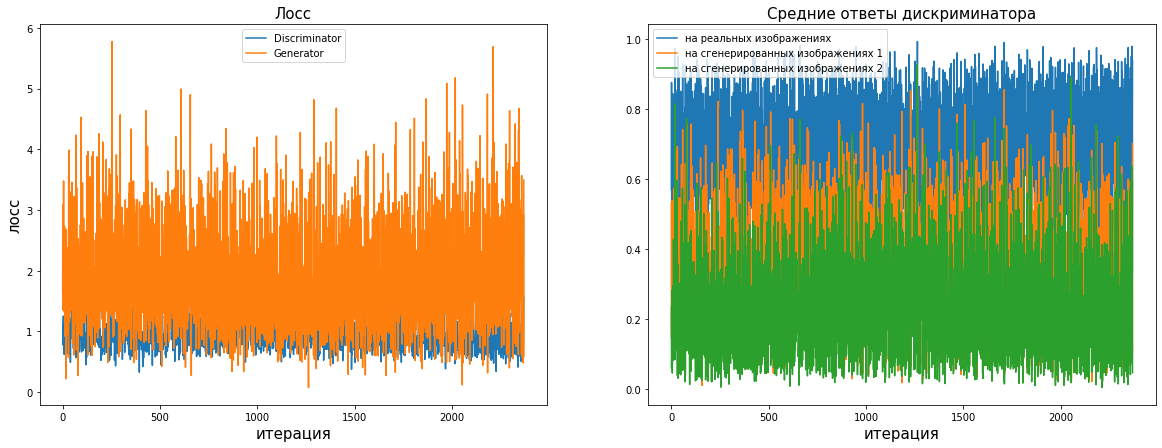

In [ ]:
discr_net, gen_net, examples = train(discr_net, 
                                     gen_net, 
                                     criterion, 
                                     discr_optim, 
                                     gen_optim, dataloader, 30,
                                     fixed_vectors=fixed_vectors)

Визуализация нескольких полученных изображений

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


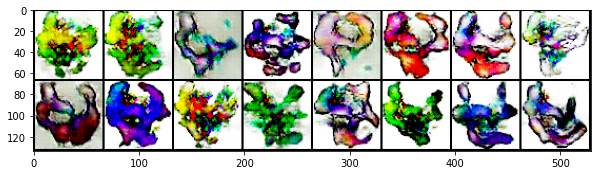

In [ ]:
fig = plt.figure(figsize=(10, 10))
plt.imshow(np.transpose(examples[20], (1, 2, 0)))

Попробуем улучшить качество модели и усложнить переобучение дискриминатора

### Добавление Attention

Добавим в обе модели слой self-attention, позволяющий контролировать удаленные друг от друга участки изображения и поддерживать консистентность

In [ ]:
class Attention(nn.Module):
  def __init__(self, D_in):
    super().__init__()

    self.key = nn.Conv2d(D_in, D_in // 4, 1)
    self.query = nn.Conv2d(D_in, D_in // 4, 1)
    self.value = nn.Conv2d(D_in, D_in, 1)
    self.softmax = nn.Softmax(-1)

    #обучаемый параметр, отвечающий за то, с каким весом учитывать attention
    self.coef = nn.Parameter(torch.zeros(1))

  def forward(self, input):
    size_of_batch, channels, w, h = input.size()

    keys = self.key(input).view(size_of_batch, -1, w * h)
    queries = self.query(input).view(size_of_batch, -1, w * h)
    values = self.value(input).view(size_of_batch, -1, w * h)

    attention = self.softmax(torch.bmm(queries.permute(0, 2, 1), keys))
    output = torch.bmm(values, attention.permute(0, 2, 1))
    output = self.coef * output.view(size_of_batch, channels, w, h) + input

    return output

In [ ]:
class Generator_with_attention(nn.Module):
  def __init__(self, input_length):
    super().__init__()
    self.layers = nn.Sequential(
        nn.ConvTranspose2d(input_length, 512, 4, 1, 0, bias=False),
        nn.BatchNorm2d(512),
        nn.ReLU(True),
        # 512 x 4 x 4

        nn.ConvTranspose2d(512, 256, 4, 2, 1, bias=False),
        nn.BatchNorm2d(256),
        nn.ReLU(True),
        # 256 x 8 x 8

        nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),
        nn.BatchNorm2d(128),
        nn.ReLU(True),
        # 128 x 16 x 16

        nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False),
        nn.BatchNorm2d(64),
        nn.ReLU(True),
        # 64 x 32 x 32

        Attention(64),

        nn.ConvTranspose2d(64, 3, 4, 2, 1, bias=False),
        nn.Tanh()
        # 3 x 64 x 64
    )

  def forward(self, input):
    return self.layers(input)

In [ ]:
class Discriminator_with_attention(nn.Module):
  def __init__(self):
    super().__init__()
    self.layers = nn.Sequential(
        # 3 x 64 x 64

        nn.Conv2d(3, 64, 4, 2, 1, bias=False),
        nn.BatchNorm2d(64),
        nn.LeakyReLU(0.2, inplace=True),
        # 64 x 32 x 32

        nn.Conv2d(64, 128, 4, 2, 1, bias=False),
        nn.BatchNorm2d(128),
        nn.LeakyReLU(0.2, inplace=True),
        # 128 x 16 x 16

        nn.Conv2d(128, 256, 4, 2, 1, bias=False),
        nn.BatchNorm2d(256),
        nn.LeakyReLU(0.2, inplace=True),
        # 256 x 8 x 8

        Attention(256),

        nn.Conv2d(256, 512, 4, 2, 1, bias=False),
        nn.BatchNorm2d(512),
        nn.LeakyReLU(True),
        # 512 x 4 x 4

        nn.Conv2d(512, 1, 4, 1, 0, bias=False),
        nn.Sigmoid()
    )

  def forward(self, input):
    return self.layers(input)

In [ ]:
discr_with_attention_net = Discriminator_with_attention().to(device)
gen_with_attention_net = Generator_with_attention(100).to(device)
discr_with_attention_net.apply(random_weights_init)
gen_with_attention_net.apply(random_weights_init)

criterion = functional.binary_cross_entropy

discr_lr = 0.0001
gen_lr = 0.003
discr_optim = optim.Adam(discr_with_attention_net.parameters(), lr=discr_lr, betas=(0.5, 0.9))
gen_optim = optim.Adam(gen_with_attention_net.parameters(), lr=gen_lr, betas=(0.5, 0.9))

fixed_vectors = torch.rand(16, 100, 1, 1, device=device)

Epoch 30 of 30 took 16.255s


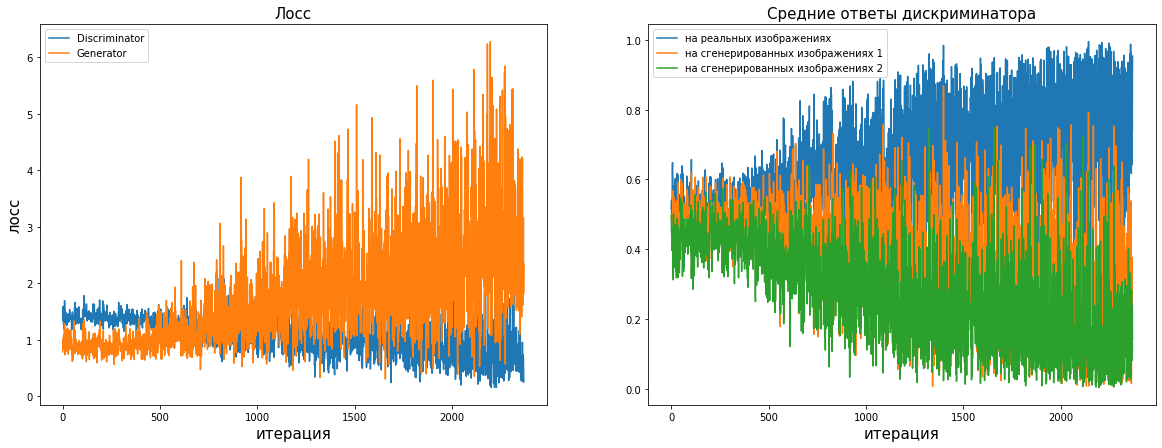

In [ ]:
discr_with_attention_net, gen_with_attention_net, examples = train(
                                     discr_with_attention_net, 
                                     gen_with_attention_net, 
                                     criterion, 
                                     discr_optim, 
                                     gen_optim, dataloader, 30,
                                     fixed_vectors=fixed_vectors)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


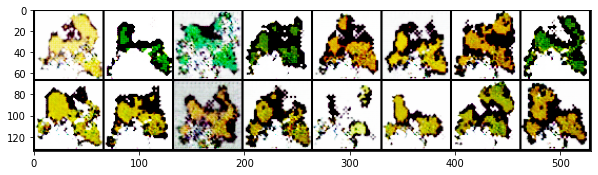

In [ ]:
fig = plt.figure(figsize=(10, 10))
plt.imshow(np.transpose(examples[-1], (1, 2, 0)))

Видно, что дискриминатор стал переобучаться быстрее, так как добавление attention увеличило количество обучаемых параметров и усложнило модель. Попробуем вместо этого использовать старый дискриминатор и генератор с attention

In [ ]:
discr_net = Discriminator().to(device)
gen_with_attention_net = Generator_with_attention(100).to(device)
discr_net.apply(random_weights_init)
gen_with_attention_net.apply(random_weights_init)

criterion = functional.binary_cross_entropy

discr_lr = 0.0001
gen_lr = 0.003
discr_optim = optim.Adam(discr_net.parameters(), lr=discr_lr, betas=(0.5, 0.9))
gen_optim = optim.Adam(gen_with_attention_net.parameters(), lr=gen_lr, betas=(0.5, 0.9))

fixed_vectors = torch.rand(16, 100, 1, 1, device=device)

Epoch 30 of 30 took 15.577s


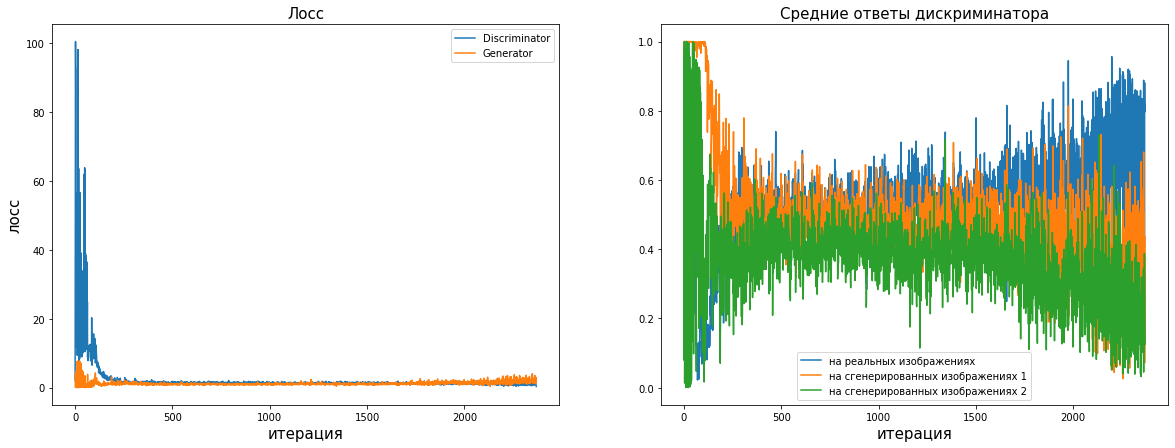

In [ ]:
discr_net, gen_with_attention_net, examples = train(
                                     discr_net, 
                                     gen_with_attention_net, 
                                     criterion, 
                                     discr_optim, 
                                     gen_optim, dataloader, 30,
                                     fixed_vectors=fixed_vectors)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


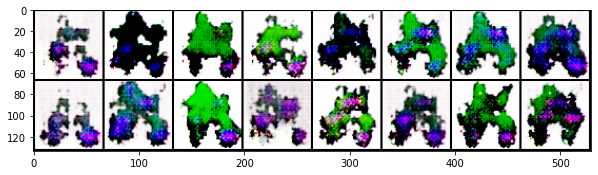

In [ ]:
fig = plt.figure(figsize=(10, 10))
plt.imshow(np.transpose(examples[20], (1, 2, 0)))

Теперь переобучение начинается позже, но проблема полностью не решилась

### Устранение переобучения дискриминатора

Чтобы еще усложнить работу дискриминатора, добавим шум к labels

In [ ]:
def smart_train(
    discr_model, 
    gen_model,
    criterion,
    discr_optim,
    discr_gen,
    dataloader,
    num_epochs=10,
    fixed_vectors=None,
    adjust_lr=False
):
    '''
    Функция для обучения модели и вывода лосса и метрики во время обучения.

    :param discr_model: дискриминатор
    :param gen_model: генератор
    :param criterion: функция потерь
    :param discr_optim: метод оптимизации дискриминатора
    :param discr_gen: метод оптимизации генератора
    :param dataloder: генератор батчей для обучения
    :param num_epochs: количество эпох
    :fixed_vectors: фиксированный шум для визуализации
    :adjust_lr: менять ли lr в процессе обучения
    '''
    examples = []
    gen_losses = []
    discr_losses = []
    true_images_score = []
    fake_images_score = []
    gen_score = []
    num_batches = len(dataloader)


    for epoch in range(num_epochs):
      start_time = time.time()

      for batch in dataloader:
        batch = batch[0].to(device)

        # Обучение дискриминатора на настоящих покемонах
        discr_optim.zero_grad()
        output = discr_model(batch).view(-1)

        labels = torch.ones(batch.size(0), device=device) 
        labels -= torch.rand(batch.size(0), device=device) * 0.1
        loss_discr_1 = criterion(output, labels)
        loss_discr_1.backward()

        true_images_score.append(output.mean().item())

        # Обучение дискриминатора на сгенерированных изображениях
        noise = torch.randn(batch.size(0), 100, 1, 1, device=device)
        fake_batch = gen_model(noise)
        #noised_batch = 
        output = discr_model(fake_batch.detach()).view(-1)

        labels = torch.zeros(batch.size(0), device=device)
        labels += torch.rand(batch.size(0), device=device) * 0.1
        loss_discr_2 = criterion(output, labels)
        loss_discr_2.backward()

        loss_discr = loss_discr_1.item() + loss_discr_2.item()
        discr_losses.append(loss_discr)
        discr_optim.step()

        fake_images_score.append(output.mean().item())

        # Обучение генератора
        gen_optim.zero_grad()

        noise = torch.randn(batch.size(0), 100, 1, 1, device=device)
        fake_batch = gen_model(noise)
        output = discr_model(fake_batch).view(-1)

        labels = torch.ones(batch.size(0), device=device)
        loss_gen = criterion(output, labels)
        loss_gen.backward()
        gen_losses.append(loss_gen.item())

        gen_optim.step()
        gen_score.append(output.mean().item())

      if adjust_lr and epoch > 0:
        true_score = np.mean(true_images_score[-num_batches:])
        fake_score = np.mean(gen_score[-num_batches:])
        if true_score - fake_score > 0.4:
            discr_optim.param_groups[0]['lr'] *= 0.9

      # Визуализация
      clear_output(wait=True)

      # Печатаем результаты после каждой эпохи
      print("Epoch {} of {} took {:.3f}s".format(
          epoch + 1, num_epochs, time.time() - start_time))
      
      fig = plt.figure(figsize=(20, 7))

      plt.subplot(1,2,1)
      plt.title('Лосс', fontsize=15)
      plt.plot(discr_losses, label='Discriminator')
      plt.plot(gen_losses, label='Generator')
      plt.ylabel('лосс', fontsize=15)
      plt.xlabel('итерация', fontsize=15)
      plt.legend()

      plt.subplot(1,2,2)
      plt.title('Средние ответы дискриминатора', fontsize=15)
      plt.plot(true_images_score, label='на реальных изображениях')
      plt.plot(fake_images_score, label='на сгенерированных изображениях 1')
      plt.plot(gen_score, label='на сгенерированных изображениях 2')
      plt.xlabel('итерация', fontsize=15)
      plt.legend()

      plt.show()
      
      #Сохраняем результаты генератора на фиксированном шуме
      with torch.no_grad():
        generated_images = gen_model(fixed_vectors).detach().cpu()
      examples.append(utils.make_grid(generated_images, padding=2, normalized=True))

        
    return discr_model, gen_model, examples 

Проверим работу нового train на модели без attention

In [ ]:
discr_net = Discriminator().to(device)
gen_net = Generator(100).to(device)
discr_net.apply(random_weights_init)
gen_net.apply(random_weights_init)

criterion = functional.binary_cross_entropy

discr_lr = 0.0001
gen_lr = 0.003
discr_optim = optim.Adam(discr_net.parameters(), lr=discr_lr, betas=(0.5, 0.9))
gen_optim = optim.Adam(gen_net.parameters(), lr=gen_lr, betas=(0.5, 0.9))

fixed_vectors = torch.rand(16, 100, 1, 1, device=device)

Epoch 60 of 60 took 12.044s


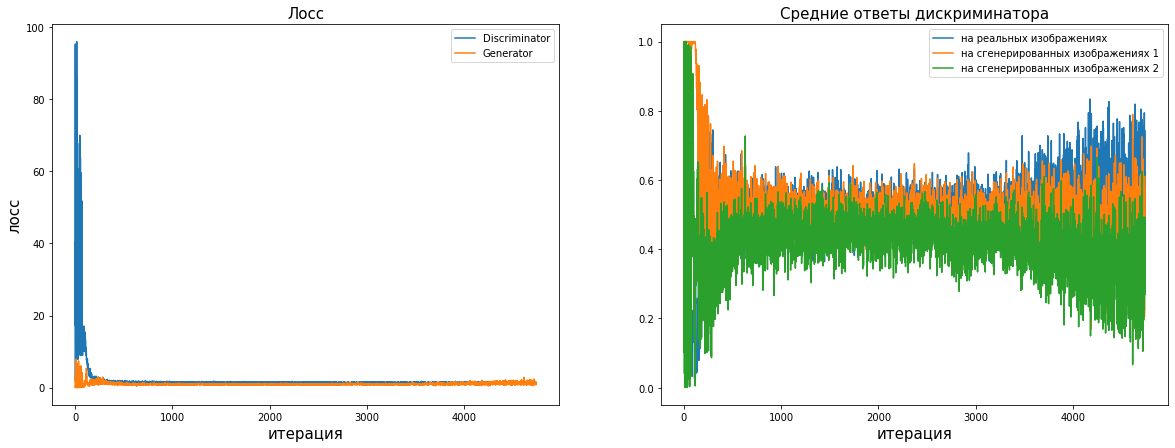

In [ ]:
discr_net, gen_net, examples = smart_train(
                                     discr_net, 
                                     gen_net, 
                                     criterion, 
                                     discr_optim, 
                                     gen_optim, dataloader, 60,
                                     fixed_vectors=fixed_vectors)

Графики заметно улучшились, посмотрим на результат

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


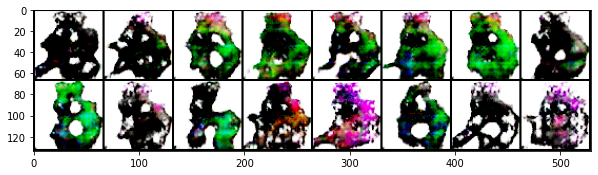

In [ ]:
fig = plt.figure(figsize=(10, 10))
plt.imshow(np.transpose(examples[-1], (1, 2, 0)))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


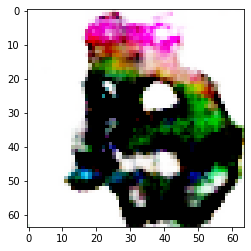

In [ ]:
with torch.no_grad():
  plt.imshow(np.transpose(gen_net(torch.rand(1, 100, 1, 1, device=device)).detach().cpu()[0], (1, 2, 0)))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


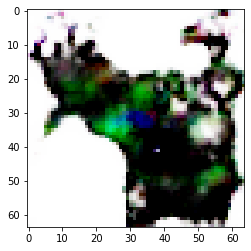

In [ ]:
with torch.no_grad():
  plt.imshow(np.transpose(gen_net(torch.randn(1, 100, 1, 1, device=device)).detach().cpu()[0], (1, 2, 0)))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


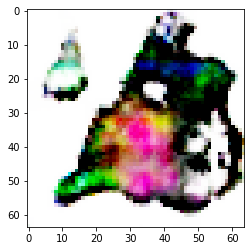

In [ ]:
with torch.no_grad():
  plt.imshow(np.transpose(gen_net(torch.randn(1, 100, 1, 1, device=device)).detach().cpu()[0], (1, 2, 0)))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


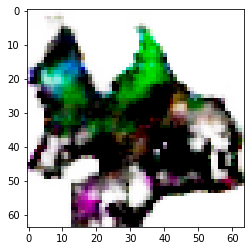

In [ ]:
with torch.no_grad():
  plt.imshow(np.transpose(gen_net(torch.randn(1, 100, 1, 1, device=device)).detach().cpu()[0], (1, 2, 0)))

Сгенерированные изображения уже более менее похожи на каких-то существ. Сможем ли мы улучшить качество добавлением attention?

In [ ]:
discr_net = Discriminator().to(device)
gen_with_attention_net = Generator_with_attention(100).to(device)
discr_net.apply(random_weights_init)
gen_with_attention_net.apply(random_weights_init)

criterion = functional.binary_cross_entropy

discr_lr = 0.0001
gen_lr = 0.003
discr_optim = optim.Adam(discr_net.parameters(), lr=discr_lr, betas=(0.5, 0.9))
gen_optim = optim.Adam(gen_with_attention_net.parameters(), lr=gen_lr, betas=(0.5, 0.9))

fixed_vectors = torch.randn(16, 100, 1, 1, device=device)

Epoch 60 of 60 took 15.472s


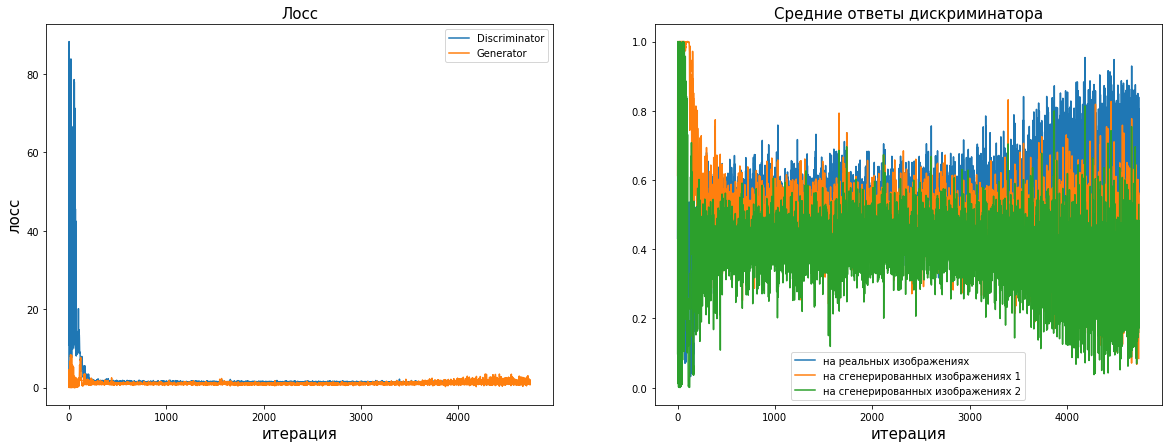

In [ ]:
discr_net, gen_with_attention_net, examples = smart_train(
                                     discr_net, 
                                     gen_with_attention_net, 
                                     criterion, 
                                     discr_optim, 
                                     gen_optim, dataloader, 60,
                                     fixed_vectors=fixed_vectors)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


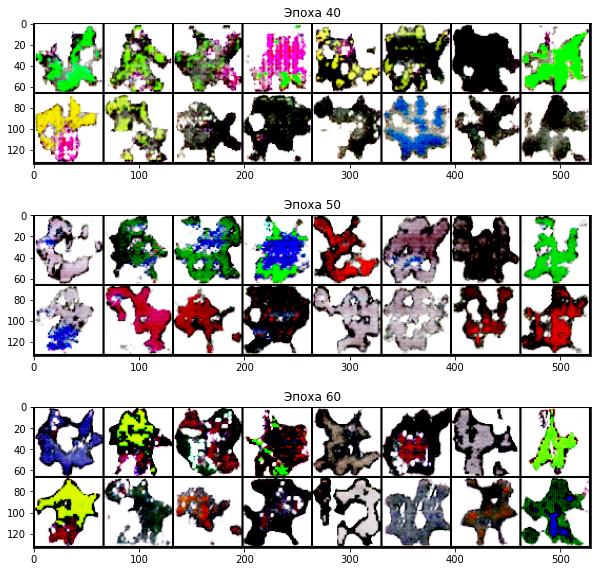

In [ ]:
fig = plt.figure(figsize=(10, 10))
plt.subplot(3, 1, 1)
plt.imshow(np.transpose(examples[39], (1, 2, 0)))
plt.title('Эпоха 40')
plt.subplot(3, 1, 2)
plt.imshow(np.transpose(examples[49], (1, 2, 0)))
plt.title('Эпоха 50')
plt.subplot(3, 1, 3)
plt.imshow(np.transpose(examples[-1], (1, 2, 0)))
plt.title('Эпоха 60');

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


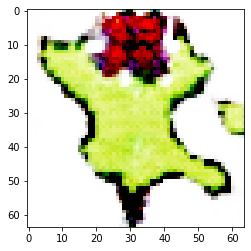

In [ ]:
with torch.no_grad():
  plt.imshow(np.transpose(gen_with_attention_net(torch.randn(1, 100, 1, 1, device=device)).detach().cpu()[0], (1, 2, 0)))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


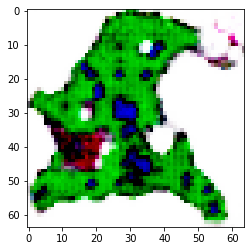

In [ ]:
with torch.no_grad():
  plt.imshow(np.transpose(gen_with_attention_net(torch.randn(1, 100, 1, 1, device=device)).detach().cpu()[0], (1, 2, 0)))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


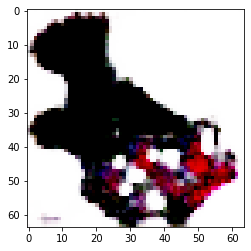

In [ ]:
with torch.no_grad():
  plt.imshow(np.transpose(gen_with_attention_net(torch.randn(1, 100, 1, 1, device=device)).detach().cpu()[0], (1, 2, 0)))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


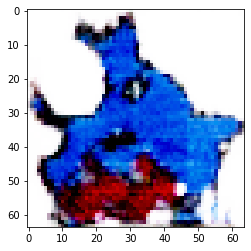

In [ ]:
with torch.no_grad():
  latent_vector = torch.randn(1, 100, 1, 1, device=device)
  plt.imshow(np.transpose(gen_with_attention_net(latent_vector).detach().cpu()[0], (1, 2, 0)))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


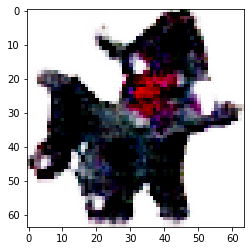

In [ ]:
with torch.no_grad():
  latent_vector = torch.randn(1, 100, 1, 1, device=device)
  plt.imshow(np.transpose(gen_with_attention_net(latent_vector).detach().cpu()[0], (1, 2, 0)))

In [ ]:
# torch.save(discr_net.state_dict(), 'discr_net')
# torch.save(gen_with_attention_net.state_dict(), 'gen_with_attention_net')

Хотя ответы на реальных и фейковых изображениях уже довольно сильно отличаются, дискриминатор все еще иногда ошибается, а значит можно потренировать модель еще несколько эпох

Epoch 30 of 30 took 15.521s


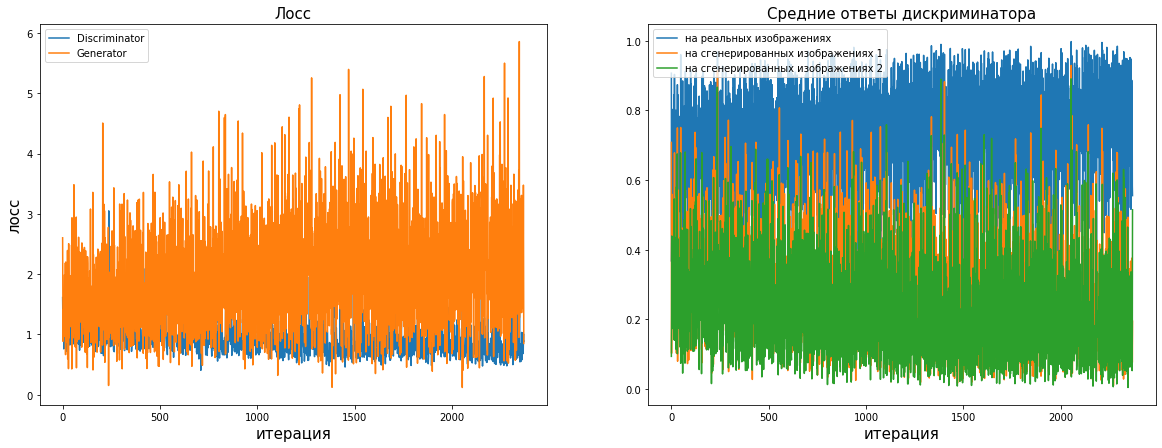

In [ ]:
discr_net.load_state_dict(torch.load('discr_net'))
gen_with_attention_net.load_state_dict(torch.load('gen_with_attention_net'))

discr_lr = 0.0001
gen_lr = 0.003
discr_optim = optim.Adam(discr_net.parameters(), lr=discr_lr, betas=(0.5, 0.9))
gen_optim = optim.Adam(gen_with_attention_net.parameters(), lr=gen_lr, betas=(0.5, 0.9))

discr_net, gen_with_attention_net, examples = smart_train(
                                     discr_net, 
                                     gen_with_attention_net, 
                                     criterion, 
                                     discr_optim, 
                                     gen_optim, dataloader, 30,
                                     fixed_vectors=fixed_vectors)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


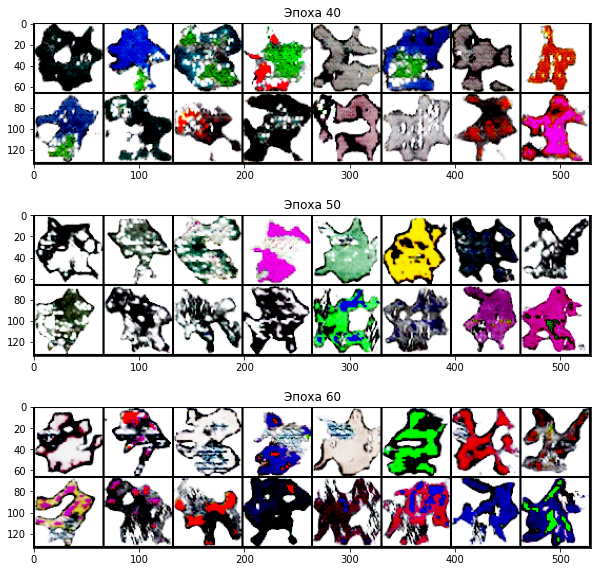

In [ ]:
fig = plt.figure(figsize=(10, 10))
plt.subplot(3, 1, 1)
plt.imshow(np.transpose(examples[0], (1, 2, 0)))
plt.title('Эпоха 40')
plt.subplot(3, 1, 2)
plt.imshow(np.transpose(examples[19], (1, 2, 0)))
plt.title('Эпоха 50')
plt.subplot(3, 1, 3)
plt.imshow(np.transpose(examples[-1], (1, 2, 0)))
plt.title('Эпоха 60');

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


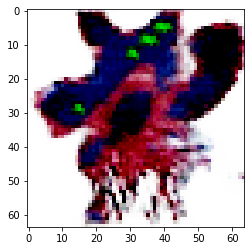

In [ ]:
with torch.no_grad():
  latent_vector = torch.randn(1, 100, 1, 1, device=device)
  plt.imshow(np.transpose(gen_with_attention_net(latent_vector).detach().cpu()[0], (1, 2, 0)))

Как и ожидалось, добавление attention помогает поддерживать целостность изображения. Теперь каждое существо имеет свой набор цветов и более однородно

### Добавление аугментаций

Увеличить размер входного датасета можно с помощью добавления аугментаций. Однако некоторые аугментации нежелательны в сгенерированных изображениях. Чтобы предотвратить просачивание аугментаций, их нужно добавлять во время тренировки модели, перед каждым вызовом дискриминатора. Будем использовать несколько реализованных в lucidrains/stylegan2-pytorch агментаций.

In [ ]:
from functools import partial

def DiffAugment(x, types=[]):
    for p in types:
        for f in AUGMENT_FNS[p]:
            x = f(x)
    return x.contiguous()

def rand_brightness(x, scale):
    x = x + (torch.rand(x.size(0), 1, 1, 1, dtype=x.dtype, device=x.device) - 0.5) * scale
    return x

def rand_contrast(x, scale):
    x_mean = x.mean(dim=[1, 2, 3], keepdim=True)
    x = (x - x_mean) * (((torch.rand(x.size(0), 1, 1, 1, dtype=x.dtype, device=x.device) - 0.5) * 2.0 * scale) + 1.0) + x_mean
    return x

def rand_translation(x, ratio=0.125):
    shift_x, shift_y = int(x.size(2) * ratio + 0.5), int(x.size(3) * ratio + 0.5)
    translation_x = torch.randint(-shift_x, shift_x + 1, size=[x.size(0), 1, 1], device=x.device)
    translation_y = torch.randint(-shift_y, shift_y + 1, size=[x.size(0), 1, 1], device=x.device)
    grid_batch, grid_x, grid_y = torch.meshgrid(
        torch.arange(x.size(0), dtype=torch.long, device=x.device),
        torch.arange(x.size(2), dtype=torch.long, device=x.device),
        torch.arange(x.size(3), dtype=torch.long, device=x.device),
    )
    grid_x = torch.clamp(grid_x + translation_x + 1, 0, x.size(2) + 1)
    grid_y = torch.clamp(grid_y + translation_y + 1, 0, x.size(3) + 1)
    x_pad = functional.pad(x, [1, 1, 1, 1, 0, 0, 0, 0])
    x = x_pad.permute(0, 2, 3, 1).contiguous()[grid_batch, grid_x, grid_y].permute(0, 3, 1, 2)
    return x

def rand_offset(x, ratio=1, ratio_h=1, ratio_v=1):
    w, h = x.size(2), x.size(3)

    imgs = []
    for img in x.unbind(dim = 0):
        max_h = int(w * ratio * ratio_h)
        max_v = int(h * ratio * ratio_v)

        value_h = random.randint(0, max_h) * 2 - max_h
        value_v = random.randint(0, max_v) * 2 - max_v

        if abs(value_h) > 0:
            img = torch.roll(img, value_h, 2)

        if abs(value_v) > 0:
            img = torch.roll(img, value_v, 1)

        imgs.append(img)

    return torch.stack(imgs)

AUGMENT_FNS = {
    'brightness': [partial(rand_brightness, scale=1.)],
    'contrast':  [partial(rand_contrast, scale=.5)],
    'offset': [rand_offset],
    'translation': [rand_translation],
}

In [ ]:
class Augment(nn.Module):
  def __init__(self, image_size):
    super().__init__()

  def forward(self, input, prob=0.4):
    if random.random() < prob:
      input = DiffAugment(input, ['brightness', 'contrast', 'offset', 'translation'])

    return input

Модифицируем train

In [ ]:
def smart_train_with_augments(
    discr_model, 
    gen_model,
    aug_model,
    criterion,
    discr_optim,
    discr_gen,
    dataloader,
    num_epochs=10,
    fixed_vectors=None,
    prob=0.4
):
    '''
    Функция для обучения модели и вывода лосса и метрики во время обучения.

    :param discr_model: дискриминатор
    :param gen_model: генератор
    :param aug_model: аугментации
    :param criterion: функция потерь
    :param discr_optim: метод оптимизации дискриминатора
    :param discr_gen: метод оптимизации генератора
    :param dataloder: генератор батчей для обучения
    :param num_epochs: количество эпох
    :fixed_vectors: фиксированный шум для визуализации
    :prob: вероятность аугментаций

    '''
    examples = []
    gen_losses = []
    discr_losses = []
    true_images_score = []
    fake_images_score = []
    gen_score = []

    for epoch in range(num_epochs):
      start_time = time.time()

      for batch in dataloader:
        batch = batch[0].to(device)
        batch = aug_model(batch, prob=prob)

        # Обучение дискриминатора на настоящих покемонах
        discr_optim.zero_grad()
        output = discr_model(batch).view(-1)

        labels = torch.ones(batch.size(0), device=device) 
        labels -= torch.rand(batch.size(0), device=device) * 0.1
        loss_discr_1 = criterion(output, labels)
        loss_discr_1.backward()

        true_images_score.append(output.mean().item())

        # Обучение дискриминатора на сгенерированных изображениях
        noise = torch.randn(batch.size(0), 100, 1, 1, device=device)
        fake_batch = gen_model(noise)
        fake_batch = aug_model(fake_batch, prob=prob)
        output = discr_model(fake_batch.detach()).view(-1)

        labels = torch.zeros(batch.size(0), device=device)
        labels += torch.rand(batch.size(0), device=device) * 0.1
        loss_discr_2 = criterion(output, labels)
        loss_discr_2.backward()

        loss_discr = loss_discr_1.item() + loss_discr_2.item()
        discr_losses.append(loss_discr)
        discr_optim.step()

        fake_images_score.append(output.mean().item())

        # Обучение генератора
        gen_optim.zero_grad()

        noise = torch.randn(batch.size(0), 100, 1, 1, device=device)
        fake_batch = gen_model(noise)
        fake_batch = aug_model(fake_batch, prob=prob)
        output = discr_model(fake_batch).view(-1)

        labels = torch.ones(batch.size(0), device=device)
        loss_gen = criterion(output, labels)
        loss_gen.backward()
        gen_losses.append(loss_gen.item())

        gen_optim.step()
        gen_score.append(output.mean().item())
        

      # Визуализация
      clear_output(wait=True)

      # Печатаем результаты после каждой эпохи
      print("Epoch {} of {} took {:.3f}s".format(
          epoch + 1, num_epochs, time.time() - start_time))
      
      fig = plt.figure(figsize=(20, 7))

      plt.subplot(1,2,1)
      plt.title('Лосс', fontsize=15)
      plt.plot(discr_losses, label='Discriminator')
      plt.plot(gen_losses, label='Generator')
      plt.ylabel('лосс', fontsize=15)
      plt.xlabel('итерация', fontsize=15)
      plt.legend()

      plt.subplot(1,2,2)
      plt.title('Средние ответы дискриминатора', fontsize=15)
      plt.plot(true_images_score, label='на реальных изображениях')
      plt.plot(fake_images_score, label='на сгенерированных изображениях 1')
      plt.plot(gen_score, label='на сгенерированных изображениях 2')
      plt.xlabel('итерация', fontsize=15)
      plt.legend()

      plt.show()
      
      #Сохраняем результаты генератора на фиксированном шуме
      with torch.no_grad():
        generated_images = gen_model(fixed_vectors).detach().cpu()
      examples.append(utils.make_grid(generated_images, padding=2, normalized=True))

        
    return discr_model, gen_model, examples 

In [ ]:
discr_net = Discriminator().to(device)
gen_with_attention_net = Generator_with_attention(100).to(device)
aug_net = Augment(64).to(device)

discr_net.load_state_dict(torch.load('discr_net_2'))
gen_with_attention_net.load_state_dict(torch.load('gen_with_attention_net_2'))

discr_lr = 0.0001
gen_lr = 0.003
discr_optim = optim.Adam(discr_net.parameters(), lr=discr_lr, betas=(0.5, 0.9))
gen_optim = optim.Adam(gen_with_attention_net.parameters(), lr=gen_lr, betas=(0.5, 0.9))

criterion = functional.binary_cross_entropy
fixed_vectors = torch.rand(16, 100, 1, 1, device=device)

Epoch 30 of 30 took 16.021s


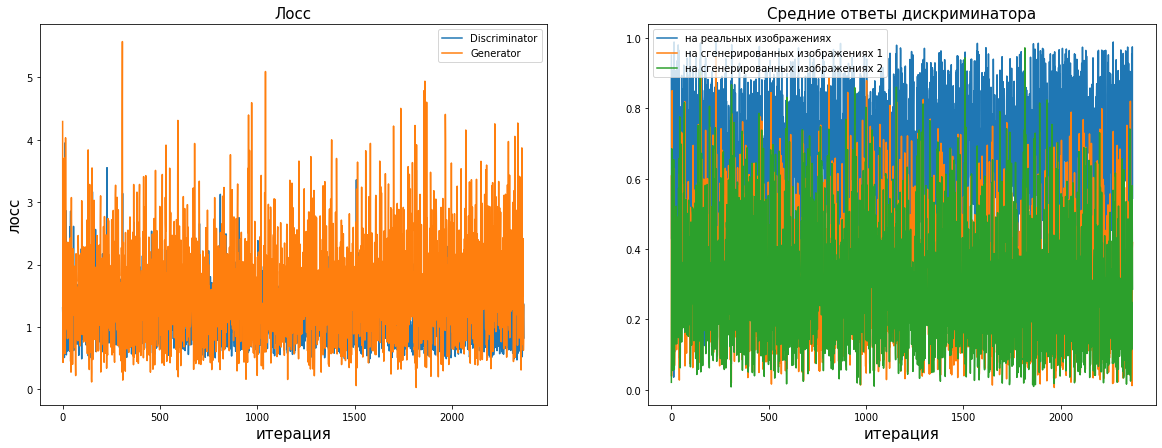

In [ ]:
discr_net, gen_with_attention_net, examples = smart_train_with_augments(
                                     discr_net, 
                                     gen_with_attention_net, 
                                     aug_net,
                                     criterion, 
                                     discr_optim, 
                                     gen_optim, dataloader, 30,
                                     fixed_vectors=fixed_vectors)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


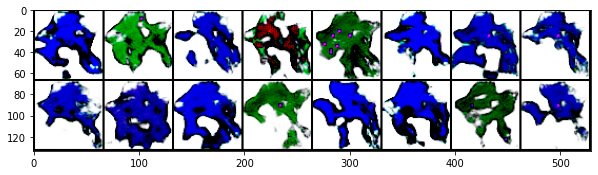

In [ ]:
fig = plt.figure(figsize=(10, 10))
plt.imshow(np.transpose(examples[-1], (1, 2, 0)))

### Вторая модель

С помощью аугментаций удается контролировать переобучение дискриминатора. Поэтому есть возможность обучить более сложную модель: с двумя attention слоями в генераторе и одним в дискриминаторе

In [ ]:
class Generator_smart(nn.Module):
  def __init__(self, input_length):
    super().__init__()
    self.layers = nn.Sequential(
        nn.ConvTranspose2d(input_length, 512, 4, 1, 0, bias=False),
        nn.BatchNorm2d(512),
        nn.ReLU(True),
        # 512 x 4 x 4

        nn.ConvTranspose2d(512, 256, 4, 2, 1, bias=False),
        nn.BatchNorm2d(256),
        nn.ReLU(True),
        # 256 x 8 x 8

        nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),
        nn.BatchNorm2d(128),
        nn.ReLU(True),
        # 128 x 16 x 16

        Attention(128),

        nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False),
        nn.BatchNorm2d(64),
        nn.ReLU(True),
        # 64 x 32 x 32

        Attention(64),

        nn.ConvTranspose2d(64, 3, 4, 2, 1, bias=False),
        nn.Tanh()
        # 3 x 64 x 64
    )

  def forward(self, input):
    return self.layers(input)

In [ ]:
class Discriminator_smart(nn.Module):
  def __init__(self):
    super().__init__()
    self.layers = nn.Sequential(
        
        nn.Conv2d(3, 64, 4, 2, 1, bias=False),
        nn.BatchNorm2d(64),
        nn.LeakyReLU(0.2, inplace=True),
        # 64 x 32 x 32

        nn.Conv2d(64, 128, 4, 2, 1, bias=False),
        nn.BatchNorm2d(128),
        nn.LeakyReLU(0.2, inplace=True),
        # 128 x 16 x 16

        nn.Conv2d(128, 256, 4, 2, 1, bias=False),
        nn.BatchNorm2d(256),
        nn.LeakyReLU(0.2, inplace=True),
        # 256 x 8 x 8

        Attention(256),

        nn.Conv2d(256, 512, 4, 2, 1, bias=False),
        nn.BatchNorm2d(512),
        nn.LeakyReLU(True),
        # 512 x 4 x 4

        nn.Conv2d(512, 1, 4, 1, 0, bias=False),
        nn.Sigmoid()
    )

  def forward(self, input):
    return self.layers(input)

In [ ]:
discr_smart_net = Discriminator_smart().to(device)
gen_smart_net = Generator_smart(100).to(device)
aug_net = Augment(64).to(device)

discr_lr = 0.0001
gen_lr = 0.003
discr_optim = optim.Adam(discr_smart_net.parameters(), lr=discr_lr, betas=(0.5, 0.9))
gen_optim = optim.Adam(gen_smart_net.parameters(), lr=gen_lr, betas=(0.5, 0.9))

criterion = functional.binary_cross_entropy
fixed_vectors = torch.randn(16, 100, 1, 1, device=device)

Epoch 60 of 60 took 17.135s


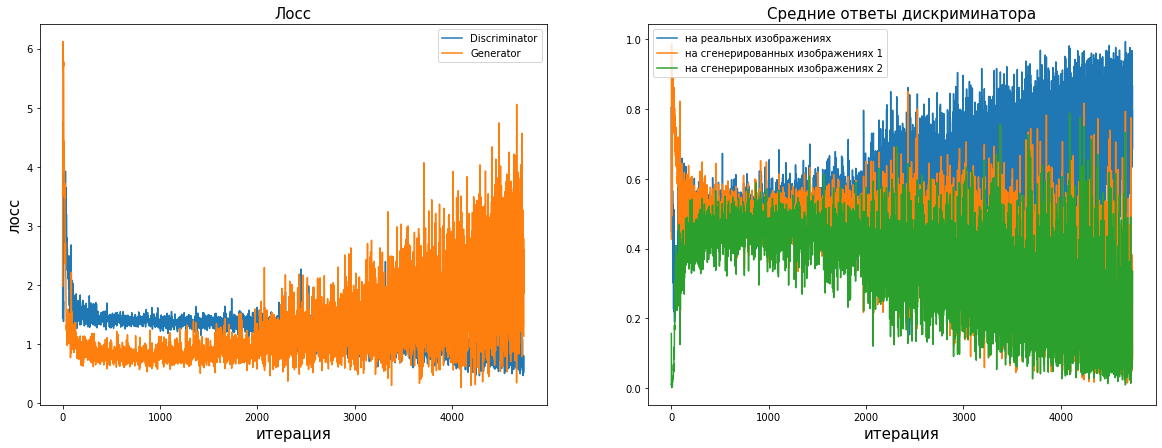

In [ ]:
discr_smart_net, gen_smart_net, examples = smart_train(
                                     discr_smart_net, 
                                     gen_smart_net, 
                                     criterion, 
                                     discr_optim, 
                                     gen_optim, dataloader, 60,
                                     fixed_vectors=fixed_vectors)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


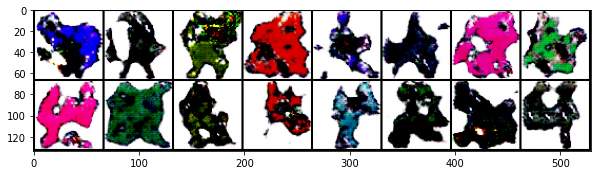

In [ ]:
fig = plt.figure(figsize=(10, 10))
plt.imshow(np.transpose(examples[-1], (1, 2, 0)))

In [ ]:
# torch.save(discr_smart_net.state_dict(), 'discr_smart_net_2')
# torch.save(gen_smart_net.state_dict(), 'gen_smart_net_2')
discr_smart_net.load_state_dict(torch.load('discr_smart_net_2'))
gen_smart_net.load_state_dict(torch.load('gen_smart_net_2'))

discr_lr = 0.0001
gen_lr = 0.003
discr_optim = optim.Adam(discr_smart_net.parameters(), lr=discr_lr, betas=(0.5, 0.9))
gen_optim = optim.Adam(gen_smart_net.parameters(), lr=gen_lr, betas=(0.5, 0.9))

Epoch 30 of 30 took 17.518s


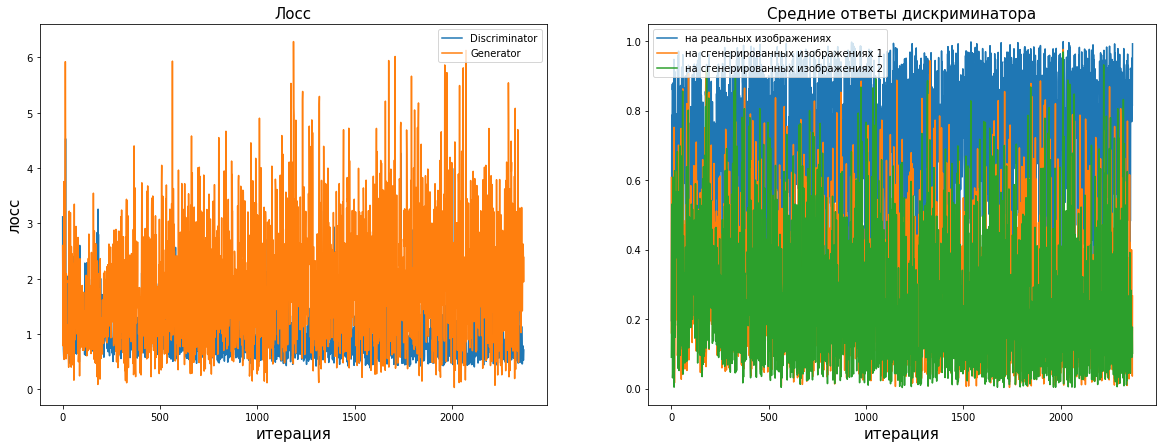

In [ ]:
discr_smart_net, gen_smart_net, examples = smart_train_with_augments(
                                     discr_smart_net, 
                                     gen_smart_net, 
                                     aug_net,
                                     criterion, 
                                     discr_optim, 
                                     gen_optim, dataloader, 30,
                                     fixed_vectors=fixed_vectors)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


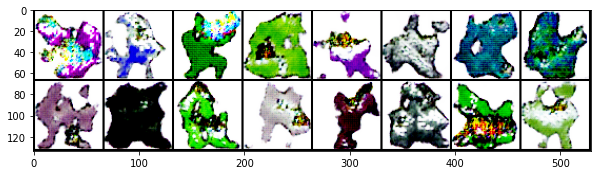

In [ ]:
fig = plt.figure(figsize=(10, 10))
plt.imshow(np.transpose(examples[-25], (1, 2, 0)))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


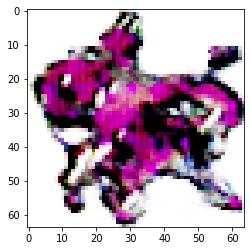

In [ ]:
with torch.no_grad():
  plt.imshow(np.transpose(gen_smart_net(torch.randn(1, 100, 1, 1, device=device)).detach().cpu()[0], (1, 2, 0)))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


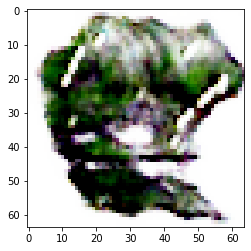

In [ ]:
with torch.no_grad():
  plt.imshow(np.transpose(gen_smart_net(torch.randn(1, 100, 1, 1, device=device)).detach().cpu()[0], (1, 2, 0)))

In [ ]:
torch.save(discr_smart_net.state_dict(), 'discr_smart_net_3')
torch.save(gen_smart_net.state_dict(), 'gen_smart_net_3')

### Загрузка моделей и результаты

#### Загрузка моделей

In [ ]:
class Generator_smart(nn.Module):
  def __init__(self, input_length):
    super().__init__()
    self.layers = nn.Sequential(
        nn.ConvTranspose2d(input_length, 512, 4, 1, 0, bias=False),
        nn.BatchNorm2d(512),
        nn.ReLU(True),
        # 512 x 4 x 4

        nn.ConvTranspose2d(512, 256, 4, 2, 1, bias=False),
        nn.BatchNorm2d(256),
        nn.ReLU(True),
        # 256 x 8 x 8

        nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),
        nn.BatchNorm2d(128),
        nn.ReLU(True),
        # 128 x 16 x 16

        Attention(128),

        nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False),
        nn.BatchNorm2d(64),
        nn.ReLU(True),
        # 64 x 32 x 32

        Attention(64),

        nn.ConvTranspose2d(64, 3, 4, 2, 1, bias=False),
        nn.Tanh()
        # 3 x 64 x 64
    )

  def forward(self, input):
    return self.layers(input)

class Attention(nn.Module):
  def __init__(self, D_in):
    super().__init__()

    self.key = nn.Conv2d(D_in, D_in // 4, 1)
    self.query = nn.Conv2d(D_in, D_in // 4, 1)
    self.value = nn.Conv2d(D_in, D_in, 1)
    self.softmax = nn.Softmax(-1)

    #обучаемый параметр, отвечающий за то, с каким весом учитывать attention
    self.coef = nn.Parameter(torch.zeros(1))

  def forward(self, input):
    size_of_batch, channels, w, h = input.size()

    keys = self.key(input).view(size_of_batch, -1, w * h)
    queries = self.query(input).view(size_of_batch, -1, w * h)
    values = self.value(input).view(size_of_batch, -1, w * h)

    attention = self.softmax(torch.bmm(queries.permute(0, 2, 1), keys))
    output = torch.bmm(values, attention.permute(0, 2, 1))
    output = self.coef * output.view(size_of_batch, channels, w, h) + input

    return output

class Generator_with_attention(nn.Module):
  def __init__(self, input_length):
    super().__init__()
    self.layers = nn.Sequential(
        nn.ConvTranspose2d(input_length, 512, 4, 1, 0, bias=False),
        nn.BatchNorm2d(512),
        nn.ReLU(True),
        # 512 x 4 x 4

        nn.ConvTranspose2d(512, 256, 4, 2, 1, bias=False),
        nn.BatchNorm2d(256),
        nn.ReLU(True),
        # 256 x 8 x 8

        nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),
        nn.BatchNorm2d(128),
        nn.ReLU(True),
        # 128 x 16 x 16

        nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False),
        nn.BatchNorm2d(64),
        nn.ReLU(True),
        # 64 x 32 x 32

        Attention(64),

        nn.ConvTranspose2d(64, 3, 4, 2, 1, bias=False),
        nn.Tanh()
        # 3 x 64 x 64
    )

  def forward(self, input):
    return self.layers(input)

In [ ]:
!wget https://github.com/pollinab/gan_weights/blob/main/gen_smart_net_3?raw=true
!wget https://github.com/pollinab/gan_weights/blob/main/gen_with_attention_net_2?raw=true
!wget https://github.com/pollinab/gan_weights/blob/main/examples_1?raw=true
!wget https://github.com/pollinab/gan_weights/blob/main/examples_2?raw=true

--2021-09-26 16:35:19--  https://github.com/pollinab/gan_weights/blob/main/gen_smart_net_3?raw=true
Resolving github.com (github.com)... 192.30.255.113
Connecting to github.com (github.com)|192.30.255.113|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/pollinab/gan_weights/raw/main/gen_smart_net_3 [following]
--2021-09-26 16:35:20--  https://github.com/pollinab/gan_weights/raw/main/gen_smart_net_3
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/pollinab/gan_weights/main/gen_smart_net_3 [following]
--2021-09-26 16:35:20--  https://raw.githubusercontent.com/pollinab/gan_weights/main/gen_smart_net_3
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting 

In [ ]:
gen_with_attention_net = Generator_with_attention(100)
gen_smart_net = Generator_smart(100)

gen_with_attention_net.load_state_dict(torch.load('gen_with_attention_net_2?raw=true', map_location=torch.device('cpu')))
gen_smart_net.load_state_dict(torch.load('gen_smart_net_3?raw=true', map_location=torch.device('cpu')))

<All keys matched successfully>

In [ ]:
examples_1 = torch.load('examples_1?raw=true', map_location=torch.device('cpu'))
examples_2 = torch.load('examples_2?raw=true', map_location=torch.device('cpu'))

#### Визуализация результатов

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

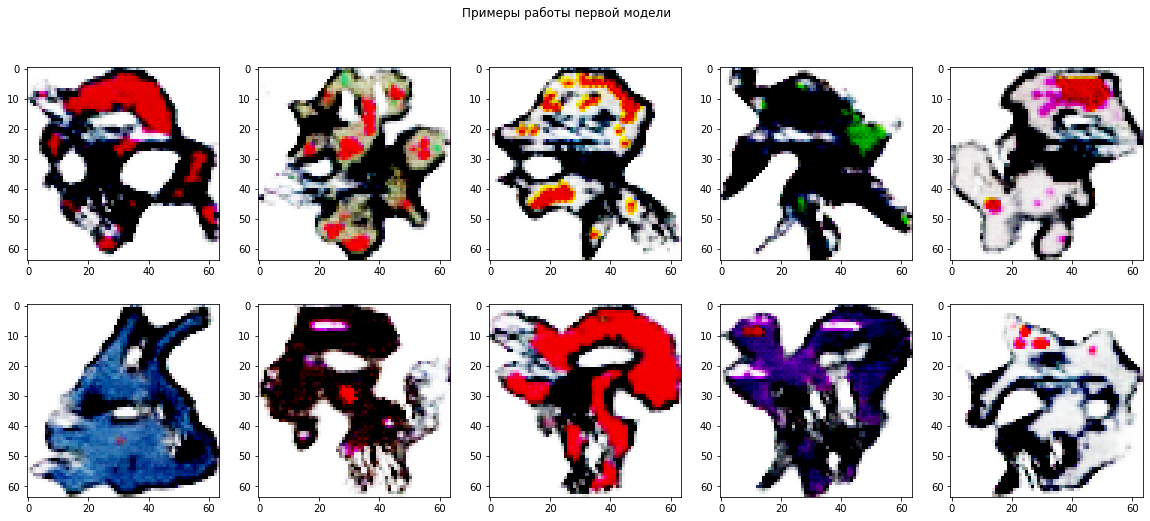

In [ ]:
plt.figure(figsize=(20, 8))

with torch.no_grad():
  for i in range(len(examples_1)):
    plt.subplot(2, 5, i+1)
    plt.imshow(np.transpose(gen_with_attention_net(examples_1[i]).detach().cpu()[0], (1, 2, 0)))

plt.suptitle("Примеры работы первой модели")
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


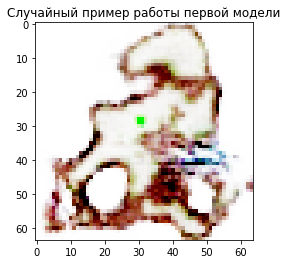

In [ ]:
with torch.no_grad():
  latent_vector = torch.randn(1, 100, 1, 1, device=device)
  plt.imshow(np.transpose(gen_with_attention_net(latent_vector).detach().cpu()[0], (1, 2, 0)))

plt.title("Случайный пример работы первой модели")
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

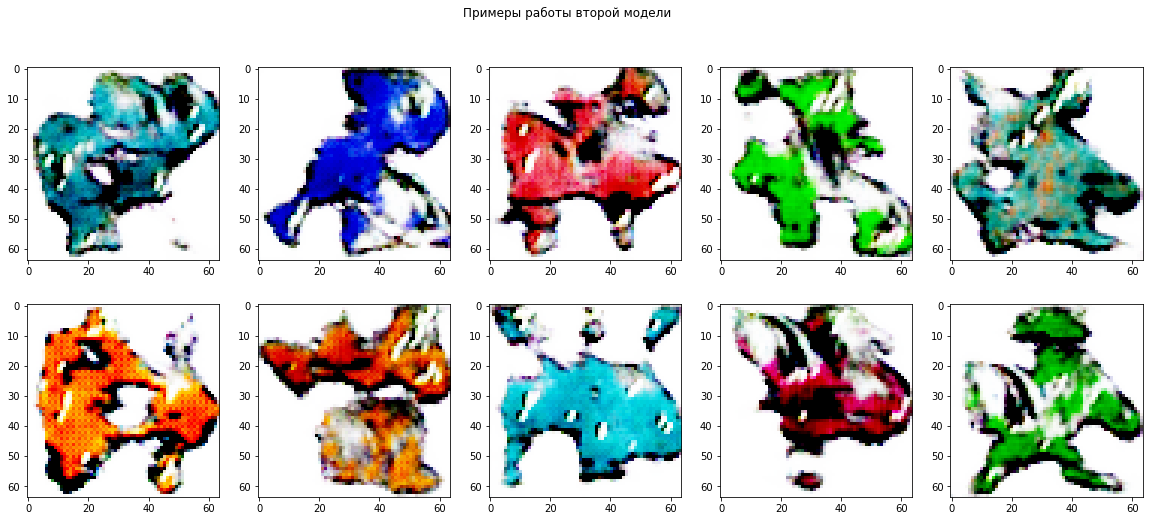

In [ ]:
plt.figure(figsize=(20, 8))

with torch.no_grad():
  for i in range(len(examples_2)):
    plt.subplot(2, 5, i+1)
    plt.imshow(np.transpose(gen_smart_net(examples_2[i]).detach().cpu()[0], (1, 2, 0)))

plt.suptitle("Примеры работы второй модели")
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


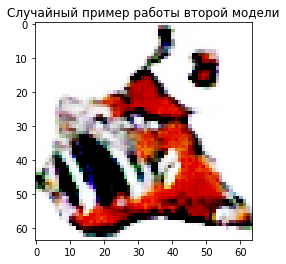

In [ ]:
with torch.no_grad():
  latent_vector = torch.randn(1, 100, 1, 1, device=device)
  plt.imshow(np.transpose(gen_smart_net(latent_vector).detach().cpu()[0], (1, 2, 0)))

plt.title("Случайный пример работы второй модели")
plt.show()